In [1]:
%matplotlib inline

# K plus proches voisins (notions)

In [2]:
# Authors: Cécile Mallet <cecile.mallet@latmos.ipsl.fr>
#          Djallel Dilmi <djallel.dilmi@latmos.ipsl.fr>
#          Aymeric Chazottes <aymeric.chazottes@latmos.ipsl.fr>
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import pandas_profiling as pp

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import DistanceMetric as DM

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# fonction d'affichage des matrices de confusion (copié/collé du site de scikit-learn)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fontsize=16):
    """
    This function printed and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Attention : les classes commencent à zero
    copier/coller d'un tutoriel sklearn?
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # suppose que les classes sont numerotees à partir de 0
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [ classes[i] for i in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    #fig, ax = plt.subplots()
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes
           #title=title,
           #ylabel='True label',
           #xlabel='Predicted label'
          )
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel('Predicted label',fontsize=fontsize)
    ax.set_xticklabels(classes,fontsize=fontsize)
    ax.set_ylabel('True label',fontsize=fontsize)
    ax.set_yticklabels(classes,fontsize=fontsize)
    
    ## Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor",fontsize=fontsize)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=fontsize,
                    color="white" if cm[i, j] > thresh else "black")
    return ax

# 1) Prise en main de l'algorithme des K plus proches voisins

L'objectif de cette partie est la prise en main de l'algorithme des kpp ainsi que sa sensibilité à ses différents paramètres.    
On pourra ainsi considérer : 
 - Impact du nombre de voisins considérés sur les performances de l'algorithme.
 - Impact de la distance et du système de poids lors du vote.

#### Chargement des données 

- le fichier DATA1_app.txt (resp. DATA1_test.txt) contient L'ensemble de données d’apprentissage (resp. de test) en dimension 2 labellisées en 2 classes nécéssaire pour ce deuxième excercice.
- les deux premières dimensions Dim 1 et 2 contiennent la description des individus tandis que la troisième variable contient les étiquettes (classes/ labels)

Quelques précisions :
- l'ensemble d'apprentissage(resp. de test) comprend 132 (resp. 99) exemples au total .

In [4]:
Data_app=pd.read_csv('DATA1_app.txt',sep='\s+', header=None,
                  names=['Dim1','Dim2','Label'],
                  dtype={'Dim1': np.float64, 'Dim2': np.float64, 'Label':np.float16})
data_app = Data_app[{'Dim1','Dim2'}].values
target_app = Data_app['Label'].values.astype(int)

In [5]:
Data_test=pd.read_csv('DATA1_test.txt',sep='\s+', header=None,
                  names=['Dim1','Dim2','Label'],
                  dtype={'Dim1': np.float64, 'Dim2': np.float64, 'Label':np.float16})
data_test = Data_test[{'Dim1','Dim2'}].values
target_test = Data_test['Label'].values.astype(int)

In [6]:
classes = np.unique(np.concatenate((target_app,target_test)))
classes

array([1, 2, 3])

#### Classifieurs K-plus proches voisins :

Le script ci-dessous compare des modèles Kppv appris avec plusieurs configurations en combinant les paramètres dans les trois listes suivantes : 

Pour chaque configuration, on profite de la faible dimension du problème pour afficher les frontières de décision et les vraies étiquettes labels pour visualiser les points mal classés.  

### Apprentissage de differents classifieurs

#### Apprentissage de classifieurs des k plus proches voisins dans différentes configurations

In [7]:
# liste_n_neigbors donne le nombre de voisins considérés
liste_n_neigbors=[1, 2, 3, 4, 5, 10, 15, 20]
# liste_distances donne les distances considérées pour comparer deux points.
liste_distances=["euclidean","manhattan"]
# liste weights donne le système de pondération des voisins lors du vote. 
liste_weights=['uniform', 'distance']

In [8]:
les_classifieurs  = list()
lesConfigurations = list()
for n_neighbors,  weights, dist in product(liste_n_neigbors, liste_weights, liste_distances):
    lesConfigurations.append({'n_neighbors':n_neighbors,'weights':weights,'dist':dist})
    les_classifieurs.append(KNN(n_neighbors,weights=weights,metric=dist,n_jobs=-1))
    les_classifieurs[-1].fit(data_app, target_app)

#### Affichage des cartes de classifications pour les différents classifieurs
On affiche aussi les données de tes avec leur classe d'origine.

In [9]:
# préparation du maillage 
h = .01  # pas du maillage
# faire resortir les frontières de décision. on attribut une couleur
# à chaque point du maillage [x_min, x_max]x[y_min, y_max].
# préciser les limites du maillage sur la première dimension Dim 1
x_min, x_max = data_app[:, 0].min()-.1 , data_app[:, 0].max()+.1
# préciser les limites du maillage sur la première dimension Dim 1
y_min, y_max = data_app[:, 1].min()-.1 , data_app[:, 1].max()+.1
# génération du maillage
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

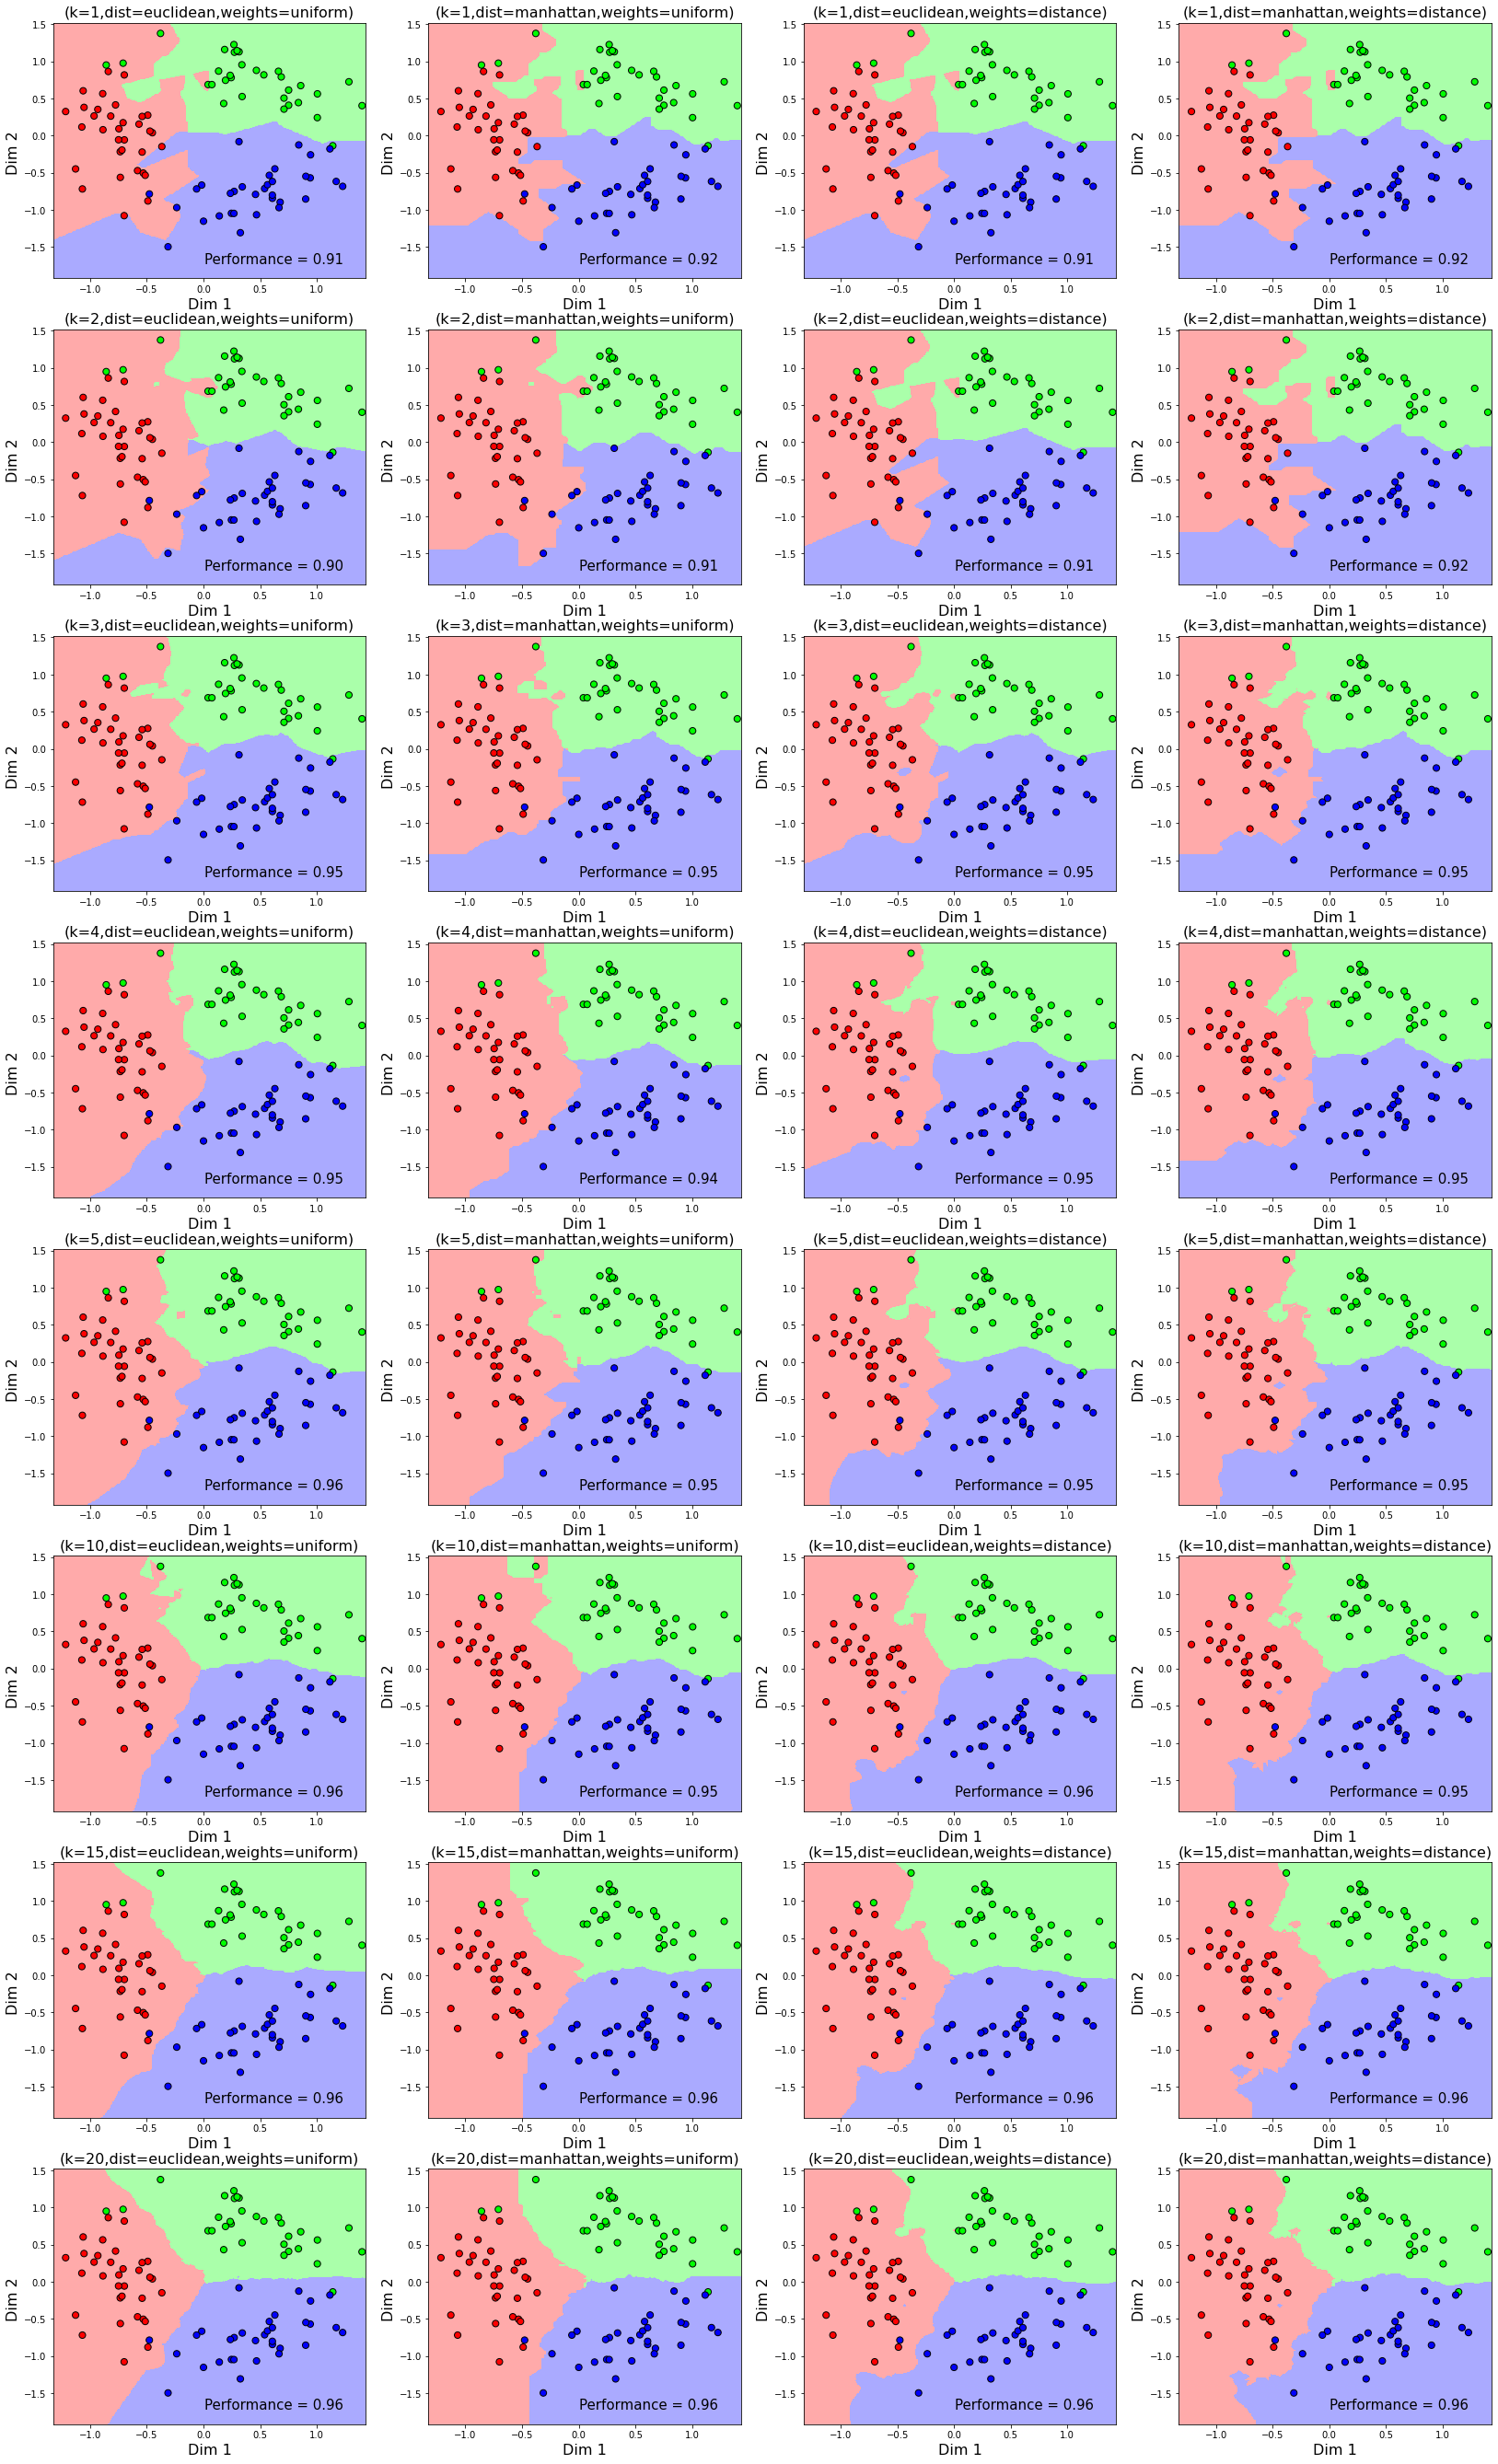

In [10]:
# créer la carte des couleurs utiliséesCreate color maps
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

figure = plt.figure(figsize=(28, 48))
for  i, knn in enumerate(les_classifieurs):
    score = knn.score(data_test, target_test)
    configuration = lesConfigurations[i]
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #
    # affichage
    ax=plt.subplot(8,4,i+1)
    # carte de classification
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # points de test
    ax.scatter(data_test[:, 0], data_test[:, 1], c=target_test,
               cmap=cmap_bold, edgecolor='k', s=50)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Dim 1',fontsize=16)
    plt.ylabel('Dim 2 ',fontsize=16)
    plt.title("(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],
                                                    configuration['dist'],
                                                    configuration['weights']),
              fontsize=16)
    ax.text(xx.max() - .2, yy.min() + .2, ('Performance = %.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')


#### Affichage des matrices de confusion pour chacun des classifieurs

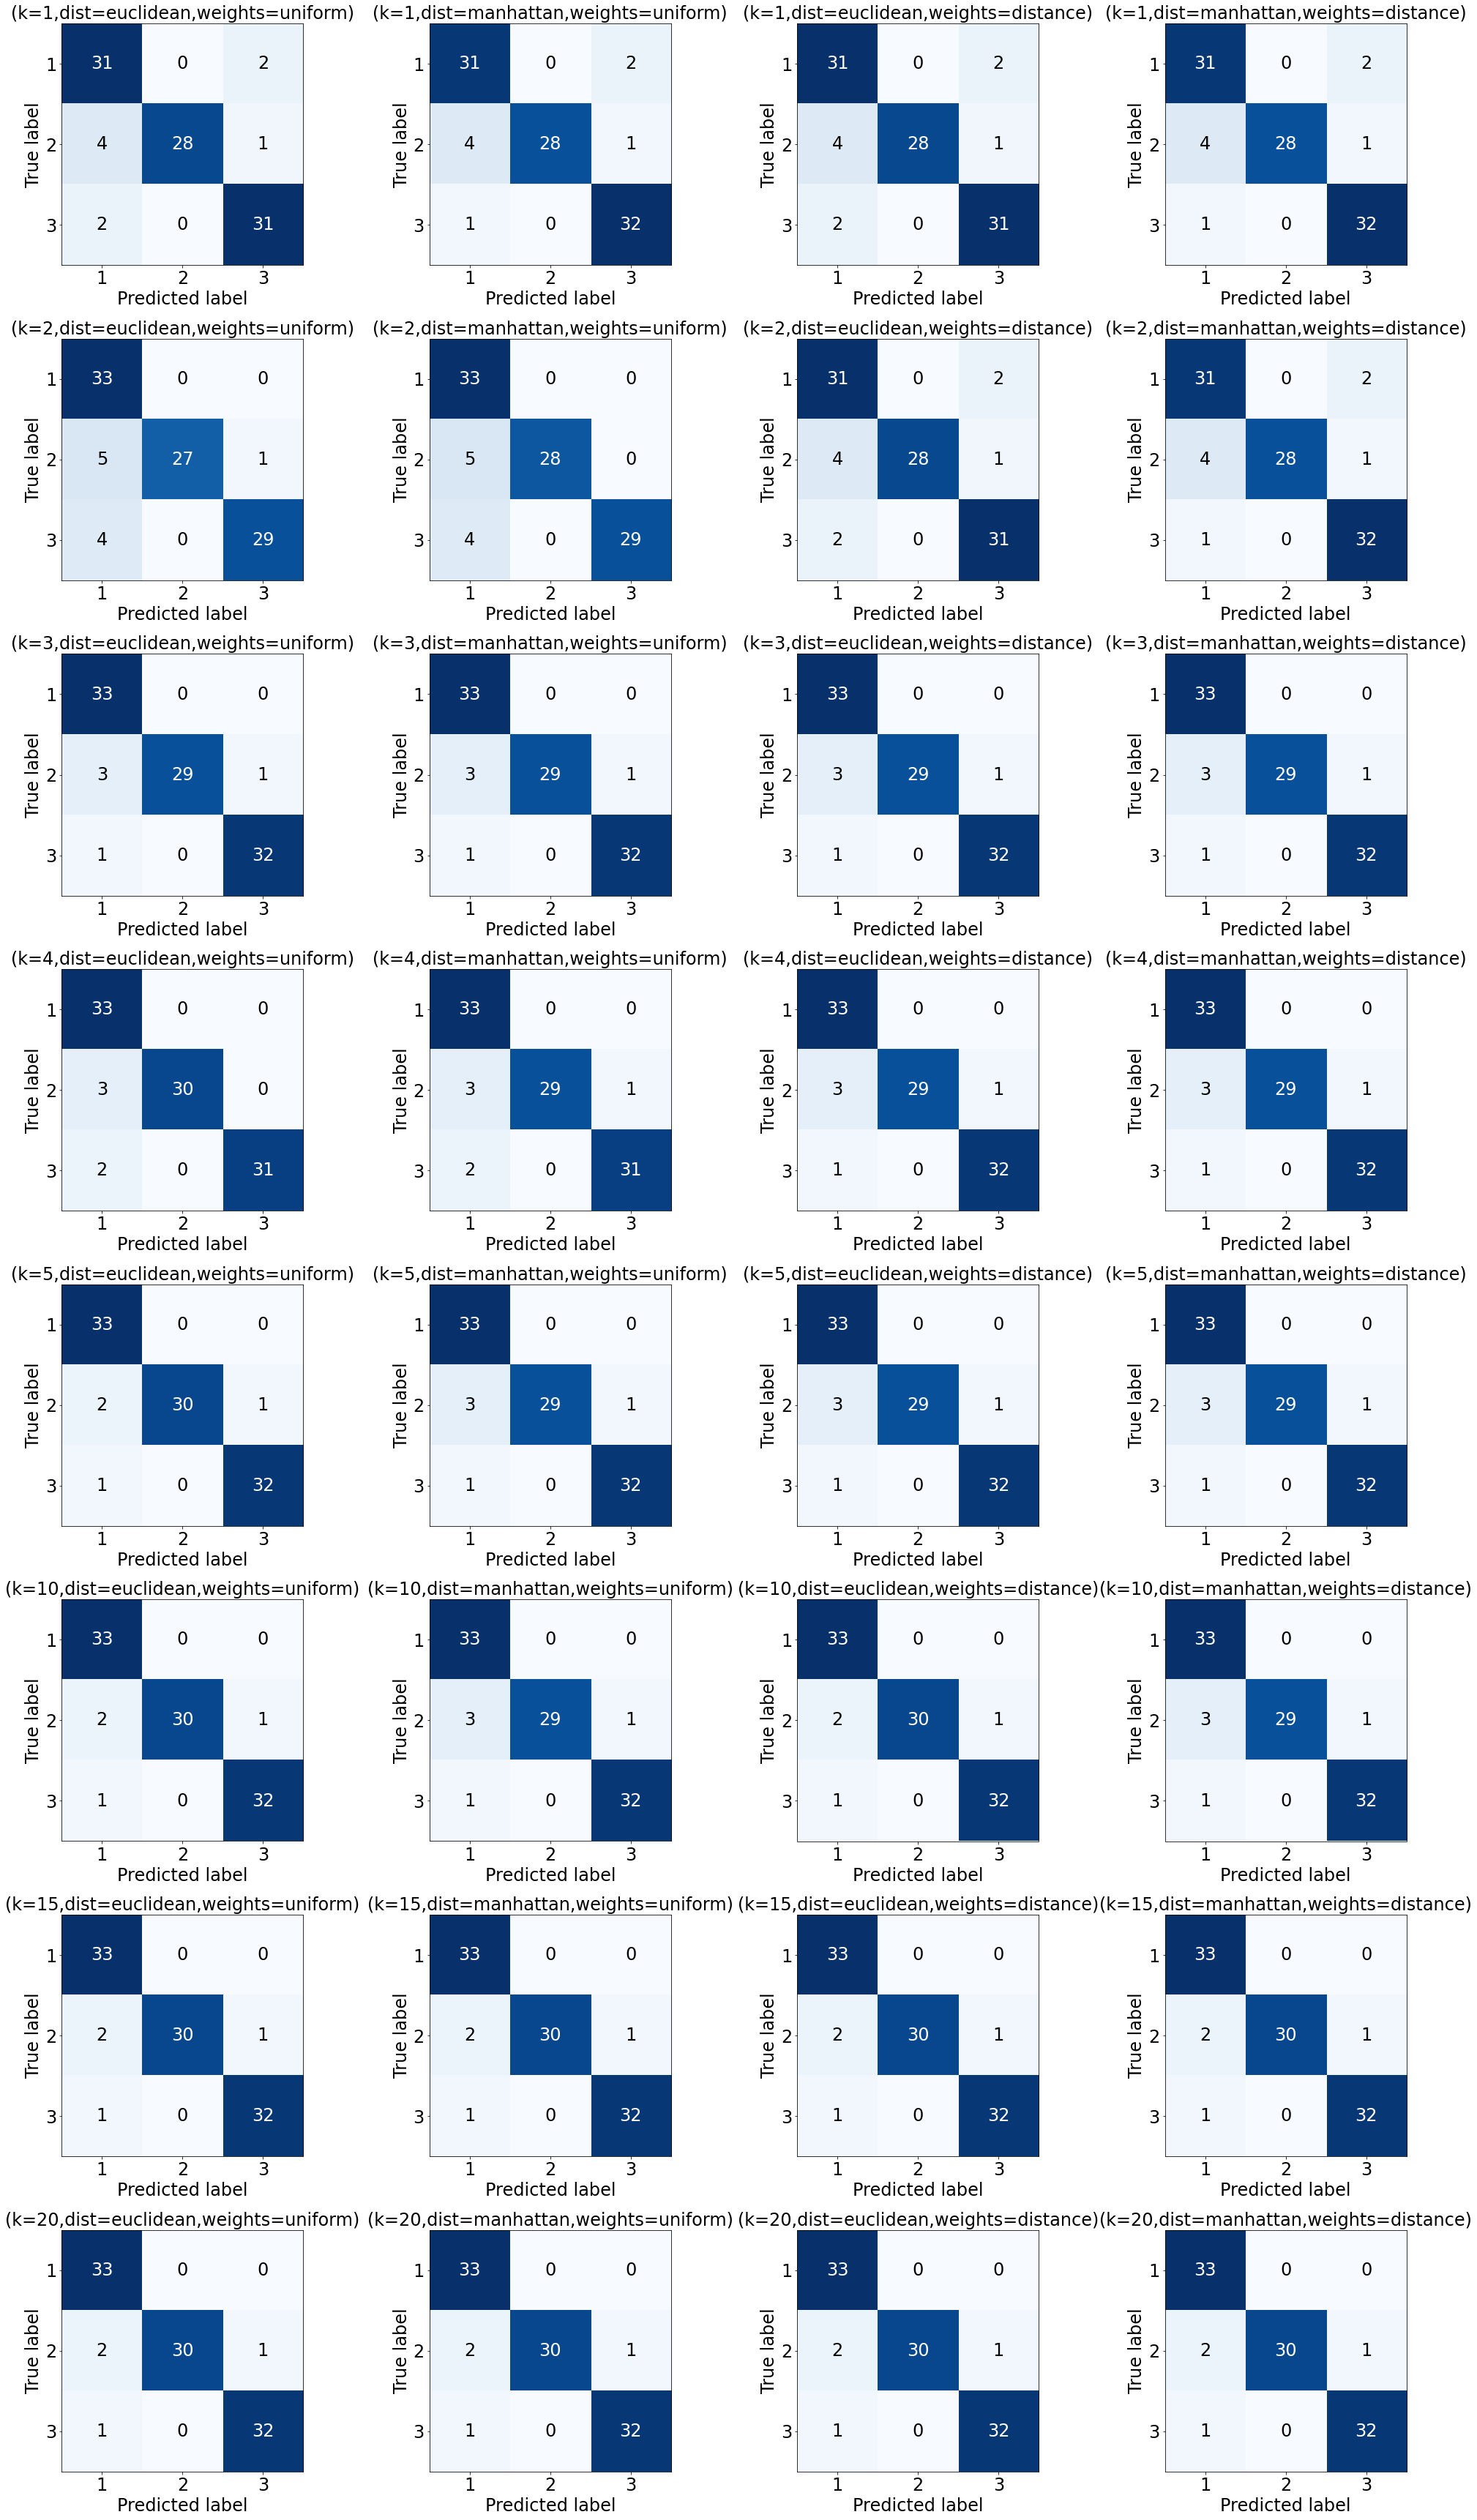

In [11]:
# créer la carte des couleurs utiliséesCreate color maps
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

figure = plt.figure(figsize=(28, 48))
for  i, knn in enumerate(les_classifieurs):
    score = knn.score(data_test, target_test)
    configuration = lesConfigurations[i]
    predict_test = knn.predict(data_test)
    #
    # affichage
    ax=plt.subplot(8,4,i+1)
    # titre
    titre = "(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],
                                                    configuration['dist'],
                                                    configuration['weights'])
    # matrice de confusion
    plot_confusion_matrix(target_test-1, predict_test-1, classes,
                          title=titre,fontsize=24)
    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())
    #plt.xlabel('Dim 1',fontsize=16)
    #plt.ylabel('Dim 2 ',fontsize=16)
    #plt.title("(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],
    #                                                configuration['dist'],
    #                                                configuration['weights']),
    #          fontsize=16)
    #ax.text(xx.max() - .2, yy.min() + .2, ('Performance = %.2f' % score).lstrip('0'),
    #        size=15, horizontalalignment='right')
plt.tight_layout()

***
**On est jamais mieux servi que par soi-même.**  
**If you want something done right, do it yourself.**

[scipy](https://www.scipy.org/) - [pandas](https://pandas.pydata.org/) - [Numpy and Scipy](https://docs.scipy.org/doc/) - [matplotlib](https://matplotlib.org/) - [scikit-learn](http://scikit-learn.org/stable/) - [seaborn](https://seaborn.pydata.org/)